# Getting my NN Training Data With Doc2Vec

In [129]:
import pandas as pd
import numpy as np

# Word Embeddings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
print(f'gensim: {gensim.__version__}')

# Text
from nltk.tokenize import word_tokenize 
from nltk.tokenize import TweetTokenizer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

# Storing as objects via serialization
from tempfile import mkdtemp
import pickle
import joblib

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Directory
import os
import yaml
import collections
import scattertext as st
import math

# Cool progress bars
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()  # Enable tracking of execution progress

## LOADING OBJECTS
processed_inbound = pd.read_pickle('objects/processed_inbound_extra.pkl')
processed = pd.read_pickle('objects/processed.pkl')

# Reading back in intents
with open(r'objects/intents.yml') as file:
    intents = yaml.load(file, Loader=yaml.FullLoader)

# Previewing
print(f'\nintents:\n{intents}')
print(f'\nprocessed:\n{processed.head()}')

gensim: 3.8.0


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel




intents:
{'battery': ['battery', 'power'], 'forgot_password': ['password', 'account', 'login'], 'payment': ['credit', 'card', 'payment', 'pay'], 'repair': ['repair', 'fix', 'broken'], 'update': ['update']}

processed:
                                    Processed Inbound  \
0   [new, update, i️, make, sure, download, yester...   
6   [hey, anyone, else, upgraded, io, issue, capit...   
12  [hello, internet, someone, explain, symbol, ke...   
13  [get, screenshot, say, iphonex, reserve, email...   
15  [thank, update, phone, even, slow, barely, wor...   

                                         Real Inbound  \
0   @AppleSupport The newest update. I️ made sure ...   
6   Hey @AppleSupport and anyone else who upgraded...   
12  Hello, internet. Can someone explain why this ...   
13  @AppleSupport I’ve got a screenshot saying my ...   
15  Thank you @AppleSupport I updated my phone and...   

                                        Real Outbound  
0   @115854 Lets take a closer look in

# Tweet Collection with Doc2Vec
I can use my Doc2Vec representation to find top 1000 Tweets most similar to a generalized intent version of a Tweet based on it's cosine similarity. 

Heuristic search refers to a search strategy that attempts to optimize a problem by iteratively improving the solution based on a given heuristic function or a cost measure. My cost measure is trying to get the closest cosine distances.

This is really cool. So I basically trained my doc2vec model with my training data, which is the processed_inbound. I can actually compute a vector based on my training data to vectorize that word.


## Training my Doc2Vec
This is a way that was developed for word2vec to generalize to paragraphs. Doc2Vec takes the average across them, and each tweet is represented as a single embedding so you have consistent dimensionality.

Word2Vec uses Continuous Bag of Words, which creates a sliding window around each word to predict it from context (surrouding words), and the Skip Gram model. Doc2Vec is based off that.

* https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
* https://radimrehurek.com/gensim/models/doc2vec.html
* https://rare-technologies.com/doc2vec-tutorial/

It's basically word to vec, but basically takes the standard word to vec model and adds in an extra vector to represent the paragraph - called a paragraph vector. Take in sequences of words, then they use them to predict the next word and check if that prediction is correct. If the prediction is correct, it does this multiple times for different combinations of words.

It's the same as word2vec, but at a document level as opposed to a word level. My implementation below had it's base from [here](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) and from scrolling through Gensim's documentation for a more granular understanding of each step.


# My Intents:

<img src="visualizations/intent_list.png" alt="Drawing" style="width: 300px;"/>

Updates:
* Decided to remove lost_replace because it's quite indistinguishable from repair because most of the customers who lost something will technically also need to fix a problem as well

### Brief Keyword Search EDA
Again, this is really useful to filter out and see what my data looks like.

In [36]:
# Search by keywords (single keyword filter)
keyword = 'update'

# Seeing what the processed Tweets look like
filt = [(i,j) for i,j in enumerate(processed['Processed Inbound']) if keyword in j]
filtered = processed.iloc[[i[0] for i in filt]]
print(f'{len(filtered)} Tweets contain the keyword {keyword}')
filtered

19942 Tweets contain the keyword update


,Processed Inbound,Real Inbound,Real Outbound
0,"[new, update, i️, make, sure, download, yester...",@AppleSupport The newest update. I️ made sure ...,@115854 Lets take a closer look into this issu...
15,"[thank, update, phone, even, slow, barely, wor...",Thank you @AppleSupport I updated my phone and...,"@115864 We'd like to help, but we'll need more..."
19,"[need, software, update, urgently, battery, la...",@AppleSupport I need the software update urgen...,@115865 Hi there! What type of device are we w...
25,"[hey, last, time, download, update, freak, pho...",Hey @115858! Last time I downloaded an update ...,@115869 We're here to help. Meet us in DM and ...
38,"[iphone, yes, io, checked, update, none, avail...","@AppleSupport iPhone 6, yes ios11. Checked for...","@116102 To make sure, is iOS 11.1 showing here..."
...,...,...,...
106624,"[dear, fuck, wish, iphone, would, stop, crash,...",Dear @115858 I fucking wish my iPhone 7 would ...,@823495 We know it's important for your iPhone...
106630,"[im, upset, update, every, time, type, anythin...","im so upset over this @115858 update, every ti...",@485591 We completely understand being upset a...
106634,"[home, button, work, phone, battery, last, lit...",@115858 My home button does not work. My phone...,@823651 We want your iPhone to work as it shou...
106636,"[whenever, new, iphone, get, launch, old, mode...",@115858 why is it whenever a new iphone gets l...,@823679 Thanks for reaching out. We know how i...


In [37]:
# This is useful for seeing the whole Tweet in output
[*filtered['Real Inbound']]

['@AppleSupport The newest update. I️ made sure to download it yesterday.',
 'Thank you @AppleSupport I updated my phone and now it is even slower and barely works. Thank you for ruining my phone.😤',
 '@AppleSupport I need the software update urgently. The battery lasts literally half a day 🙍🏼🙁@AppleSupport',
 'Hey @115858! Last time I downloaded an update my freaking phone gave me hell. Any recommendations?',
 '@AppleSupport iPhone 6, yes ios11. Checked for updates, none available. I’ve swiped up to close the app several times and I’ve restarted it 2x',
 '@115858 my PHONE app doesn’t work. Thank you for updating my #iPhone to an #ipod',
 '@115858 if my words even mean a thing to you; I am an iPhone 7 owner and have updated to your latest software and now am having the most dropped calls in history and glitch’s such as apps randomly opening and more ... #iHelp',
 '@AppleSupport why is my battery life short? I updated to 11.1, my battery is poor. Wife didn’t she likes her battery life',

In [38]:
[*filtered['Processed Inbound']]

[['new', 'update', 'i️', 'make', 'sure', 'download', 'yesterday'],
 ['thank',
  'update',
  'phone',
  'even',
  'slow',
  'barely',
  'work',
  'thank',
  'ruin',
  'phone'],
 ['need',
  'software',
  'update',
  'urgently',
  'battery',
  'last',
  'literally',
  'half',
  'day'],
 ['hey',
  'last',
  'time',
  'download',
  'update',
  'freak',
  'phone',
  'give',
  'hell',
  'recommendation'],
 ['iphone',
  'yes',
  'io',
  'checked',
  'update',
  'none',
  'available',
  'swipe',
  'close',
  'app',
  'several',
  'time',
  'restart'],
 ['phone', 'app', 'work', 'thank', 'update', 'iphone', 'ipod'],
 ['word',
  'even',
  'mean',
  'thing',
  'iphone',
  'owner',
  'update',
  'late',
  'software',
  'drop',
  'call',
  'history',
  'glitch',
  'apps',
  'randomly',
  'opening',
  'ihelp'],
 ['battery',
  'life',
  'short',
  'update',
  'battery',
  'poor',
  'wife',
  'like',
  'battery',
  'life'],
 ['day',
  'since',
  'make',
  'update',
  'phone',
  'operating',
  'system',


In [40]:
[*filtered['Real Outbound']]

["@115854 Lets take a closer look into this issue. Select the following link to join us in a DM and we'll go from there. https://t.co/GDrqU22YpT",
 "@115864 We'd like to help, but we'll need more details. What's happening on your device and which model is it? Do you have iOS 11.1?",
 '@115865 Hi there! What type of device are we working with?',
 "@115869 We're here to help. Meet us in DM and we can check on available options. https://t.co/GDrqU22YpT",
 '@116102 To make sure, is iOS 11.1 showing here: Settings &gt; General &gt; About &gt; Version? Please DM us the answer here: https://t.co/GDrqU22YpT',
 '@116102 We want you to be able to make calls on the iPhone. What exactly is going on with the Phone app?',
 '@116105  We want to help.  Send us a DM letting us know if you are updated to iOS 11.1 https://t.co/GDrqU22YpT',
 '@116334 Let’s work together on this situation. To clarify, did this start after updating to iOS 11.1? Also, which device are you using?',
 "@116336 Hi there! iOS 11.

### Data Synthesis
Basically, there are two ways I get my intent training data (1000 for each): 
* **Doc2Vec:** Some intent examples I will synthetically generate from an idealized example using doc2vec
* **Manual:** Some intent examples I will synthetically generate by duplicating and manual (like greeting, because the current data does not represent this)
* **Hybrid:** Some intents I will do a hybrid approach, where 50 percent might be my generated data, and 50 percent might be 

In [130]:
# Making my idealized dataset - generating N Tweets similar to this artificial Tweet
# This will then be concatenated to current inbound data so it can be included in the doc2vec training

# Version 1
ideal = {'Greeting': 'hi hello yo hey whats up howdy morning',
        'Update': 'have problem with update'}
# Version 2 - I realized that keywords might get the job done, and it's less risky to 
# add more words for the association power because it's doc2vec
ideal = {'battery': 'battery power', 
         'forgot_password': 'password account login',
         'payment': 'credit card payment pay',
         'update': 'update upgrade',
         'info': 'info information'
         ,'lost_replace': 'replace lost gone missing trade',
         'location': 'nearest apple location store'
        }

def add_extra(current_tokenized_data, extra_tweets):
    ''' Adding extra tweets to current tokenized data'''
    
    # Storing these extra Tweets in a list to concatenate to the inbound data
    extra_tweets = pd.Series(extra_tweets)

    # Making string form
    print('Converting to string...')
    string_processed_data = current_tokenized_data.progress_apply(" ".join)

    # Adding it to the data, updating processed_inbound
    string_processed_data = pd.concat([string_processed_data, extra_tweets], axis = 0)

    # We want a tokenized version
    tknzr = TweetTokenizer(strip_handles = True, reduce_len = True)
#     print('Tokenizing...')
#     string_processed_data.progress_apply(tknzr.tokenize)
    return string_processed_data

# Getting the lengthened data
processed_inbound_extra = add_extra(processed['Processed Inbound'], list(ideal.values()))

# Saving updated processed inbound into a serialized saved file
processed_inbound_extra.to_pickle('objects/processed_inbound_extra.pkl')

processed_inbound_extra

Converting to string...


0            new update i️ make sure download yesterday
6     hey anyone else upgraded io issue capital i️ m...
12    hello internet someone explain symbol keep app...
13    get screenshot say iphonex reserve email say h...
15    thank update phone even slow barely work thank...
                            ...                        
2                               credit card payment pay
3                                        update upgrade
4                                      info information
5                       replace lost gone missing trade
6                          nearest apple location store
Length: 76073, dtype: object

In [131]:
processed_inbound_extra[-7:]

0                      battery power
1             password account login
2            credit card payment pay
3                     update upgrade
4                   info information
5    replace lost gone missing trade
6       nearest apple location store
dtype: object

In [135]:
intents_repr

{'battery': ['battery', 'power'],
 'forgot_password': ['password', 'account', 'login'],
 'payment': ['credit', 'card', 'payment', 'pay'],
 'update': ['update', 'upgrade'],
 'info': ['info', 'information'],
 'lost_replace': ['replace', 'lost', 'gone', 'missing', 'trade'],
 'location': ['nearest', 'apple', 'location', 'store']}

In [132]:
processed_inbound_extra.shape

(76073,)

In [126]:
ideal

{'battery': 'battery power',
 'forgot_password': 'password account login',
 'payment': 'credit card payment pay',
 'update': 'update upgrade',
 'info': 'info information',
 'lost_replace': 'replace lost gone missing trade',
 'location': 'nearest apple location store'}

In [118]:
processed.shape

(76066, 3)

I first tag, then I start training my model! It's like training a neural network. As for the paramaters, I set each vector to be of 20 dimensions.

In [105]:
def train_doc2vec(string_data, max_epochs, vec_size, alpha):
    # Tagging each of the data with an ID, and I use the most memory efficient one of just using it's ID
    tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) 
                   for i, _d in enumerate(string_data)]
    
    # Instantiating my model
    model = Doc2Vec(size=vec_size, alpha=alpha, min_alpha=0.00025, min_count=1, dm =1)

    model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        model.train(tagged_data, total_examples = model.corpus_count, epochs=model.iter)
        # Decrease the learning rate
        model.alpha -= 0.0002
        # Fix the learning rate, no decay
        model.min_alpha = model.alpha

    # Saving model
    model.save("models/d2v.model")
    print("Model Saved")
    
# Training
train_doc2vec(processed_inbound_extra, max_epochs = 100, vec_size = 20, alpha = 0.025)

/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/opt/anaconda3/envs/chatbot/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  del sys.path[0]


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [116]:
# Loading in my model
model = Doc2Vec.load("models/d2v.model")

# Storing my data into a list - this is the data I will cluster
inbound_d2v = np.array([model.docvecs[i] for i in range(processed_inbound_extra.shape[0])])

# Saving
with open('objects/inbound_d2v.pkl', 'wb') as f:
    pickle.dump(inbound_d2v, f)

inbound_d2v

array([[ 1.0764736 , -0.88211083,  1.6502674 , ..., -0.52156675,
        -1.6639708 , -0.9032138 ],
       [-0.69104683, -0.21492206, -4.3119936 , ..., -1.9638066 ,
        -4.839329  , -3.0454078 ],
       [ 3.989594  , -0.56643546, -2.3382344 , ..., -3.9335248 ,
        -0.39690435,  3.1644044 ],
       ...,
       [ 1.2580909 ,  0.5197089 ,  0.09217824, ..., -2.0988    ,
        -0.15937527,  0.12537211],
       [-0.7389236 , -0.9856568 ,  1.6651227 , ..., -1.5134039 ,
         0.5436049 ,  1.9231577 ],
       [ 1.211253  ,  1.9686309 ,  3.6149867 , ...,  0.15637918,
         1.1228392 , -1.2684797 ]], dtype=float32)

In [117]:
inbound_d2v.shape

(76073, 20)

Before, we did not have a concept of distance in our vectorizers, they don't really have a specific meaning. This is a much better way because it captures the contextual representations between words! My clustering should be a lot better than tfidf or bag of words.

### What was doc2vec trained on?
One thing to keep in mind on, is finding what this embedding is trained on. We don't want it to be trained on something like academic data, because Tweets are on a completely different domain than academic papers.

Looking at the gensim [documentation](https://radimrehurek.com/gensim/models/doc2vec.html) for doc2vec, it seems to be trained same as word2vec, except now they use a paragraph context vector in addition. This means it was likely trained on Google News.

## Methodology

Initially, to get the top 1000 similar Tweets, I tried using the existing data. But I don't think that would yield the most accurate results because you're capturing not the best representative Tweet for an intent. For that reason, I made all these base representative Tweets myself (you could see this in the `ideal` dict above. The goal is to find trying to find an idealized, wholistic representation of an intent. Then from there I use my doc2vec representations to find the top 1000 tweets most similar based on cosine similarity.
### Package Exploration

In [12]:
# Finding and making idealized versions of each intent so that I can find top 1000 to it:
intents_ideal = {'app': ['app', 'prob']}
inferred_vectors = []

for keywords in intents_ideal.values():
    inferred_vectors.append(model.infer_vector(keywords))
    
inferred_vectors

[array([ 0.07985277, -0.02836085,  0.02394242, -0.05284353,  0.02267709,
         0.07228445, -0.08042882,  0.10995746, -0.08680764,  0.03262458,
        -0.08599371,  0.02658967, -0.01874685,  0.04319469,  0.01963741,
        -0.02675004, -0.08749398,  0.00777566,  0.02113561, -0.05839935],
       dtype=float32)]

In [13]:
# model.similarity(inferred_vectors[0], inbound_d2v[0])

In [14]:
'hi hello yo hey whats up'.split()

['hi', 'hello', 'yo', 'hey', 'whats', 'up']

### Finding Intent Tags
I want to get the tags of my representative Tweets because that's what doc2vec's `model.similarity` method takes in as paramater to generate top N Tweets similar to it.

In [115]:
ideal

{'battery': 'battery power',
 'forgot_password': 'password account login',
 'payment': 'credit card payment pay',
 'update': 'update upgrade',
 'info': 'info information',
 'lost_replace': 'replace lost gone missing trade',
 'location': 'nearest apple location store'}

In [ ]:
# Getting the indexes

The following code block isn't the most efficient code, and it's quite lengthy to figure out, but it works! It's basically searches all my processed inbound tweets, and looks for the tag of my representative tweets, as shown in my output and my `intents_tags` dictionary.

In [209]:
# Storing my representative tweets and intents in this dictionary
# Just need to add to this dictionary and the rest of the code block does the work for you
# To find a suitable representative tweet for this: I used the keyword EDA functions in notebook 1.1

# Version 1
intents_repr = {'Battery': ['io', 'drain', 'battery', 'iphone', 'twice', 'fast', 'io', 'help'],
    'Update': ['new', 'update', 'i️', 'make', 'sure', 'download', 'yesterday'],
    'iphone': ['instal', 'io', 'make', 'iphone', 'slow', 'work', 'properly', 'help'],
    'app': ['app', 'still', 'longer', 'able', 'control', 'lockscreen'],
    'mac': ['help','mac','app','store','open','can','not','update','macbook','pro','currently','run','o','x',
  'yosemite'], 'greeting': ['hi', 'hello', 'yo', 'hey', 'whats', 'up']
    }
# You could see that in version 1, I try to use existing tweets, but that isn't really the best strategy and
# it doesn't yield the best results

# Version 2
tknzr = TweetTokenizer(strip_handles = True, reduce_len = True)
## Just tokenizing all the values of ideal' values to be able to be fed in to matching function
# intents_repr = dict(zip(ideal.keys(), [tknzr.tokenize(v) for v in ideal.values()]))
# Pythonic way
intents_repr = {k:tknzr.tokenize(v) for k, v in ideal.items()}
print(intents_repr)

# Saving intents_repr into YAML
with open('objects/intents_repr.yml', 'w') as outfile:
    yaml.dump(intents_repr, outfile, default_flow_style=False)

# Storing tags in order of the dictionary above
tags = []

# Find the index locations of specific Tweets
def report_index_loc(tweet, intent_name):
    ''' Takes in the Tweet to find the index for and returns a report of that Tweet index along with what the 
    representative Tweet looks like'''
    tweets = []
    for i,j in enumerate(processed_inbound.apply(tknzr.tokenize)):
        if j == tweet:
            tweets.append((i, True))
        else:
            tweets.append((i, False))
    index = []
    get_index = [index.append(i[0]) if i[1] == True else False for i in tweets] # Comprehension saves space
    print(index)
    preview = processed_inbound.iloc[index]
    
    # Appending to indexes for dictionary
    tags.append(str(index[0]))
    return intent_name, str(index[0]), preview

# Reporting and storing indexes with the function
print('TAGGED INDEXES TO LOOK FOR')
for j,i in intents_repr.items():
    print('\n{} \nIndex: {}\nPreview: {}'.format(*report_index_loc(i,j)))


# Pythonic way of making new dictionary from 2 lists
intents_tags = dict(zip(intents_repr.keys(), tags))
intents_tags

{'battery': ['battery', 'power'], 'forgot_password': ['password', 'account', 'login'], 'payment': ['credit', 'card', 'payment', 'pay'], 'update': ['update', 'upgrade'], 'info': ['info', 'information'], 'lost_replace': ['replace', 'lost', 'gone', 'missing', 'trade'], 'location': ['nearest', 'apple', 'location', 'store']}
TAGGED INDEXES TO LOOK FOR
[76066]

battery 
Index: 76066
Preview: 0    battery power
dtype: object
[76067]

forgot_password 
Index: 76067
Preview: 1    password account login
dtype: object
[76068]

payment 
Index: 76068
Preview: 2    credit card payment pay
dtype: object
[76069]

update 
Index: 76069
Preview: 3    update upgrade
dtype: object
[76070]

info 
Index: 76070
Preview: 4    info information
dtype: object
[76071]

lost_replace 
Index: 76071
Preview: 5    replace lost gone missing trade
dtype: object
[76072]

location 
Index: 76072
Preview: 6    nearest apple location store
dtype: object


{'battery': '76066',
 'forgot_password': '76067',
 'payment': '76068',
 'update': '76069',
 'info': '76070',
 'lost_replace': '76071',
 'location': '76072'}

In [210]:
# Great! Now I can get the training data for my battery intent (as an example)
similar_doc = model.docvecs.most_similar('76066',topn = 1000)
# Preview
similar_doc[:5]

[('68867', 0.840837836265564),
 ('65711', 0.8240541219711304),
 ('59284', 0.8179781436920166),
 ('16218', 0.8170082569122314),
 ('9156', 0.7939690947532654)]

In [20]:
similar_doc = model.docvecs.most_similar('76070',topn = 1000)
similar_doc

[('45940', 0.8691723346710205),
 ('5978', 0.8484131097793579),
 ('41207', 0.8417021036148071),
 ('17509', 0.8316448330879211),
 ('3186', 0.8236167430877686),
 ('24317', 0.8189383745193481),
 ('46576', 0.8173151016235352),
 ('20517', 0.8077589869499207),
 ('19581', 0.8025113344192505),
 ('14863', 0.8019359111785889),
 ('19365', 0.7981585264205933),
 ('54681', 0.7921903133392334),
 ('42033', 0.7888389825820923),
 ('71900', 0.7856875061988831),
 ('1572', 0.7846237421035767),
 ('6786', 0.7828048467636108),
 ('17603', 0.7798354625701904),
 ('60716', 0.7782819867134094),
 ('788', 0.7763729095458984),
 ('42652', 0.7760578393936157),
 ('29420', 0.7756739854812622),
 ('30843', 0.7748846411705017),
 ('22740', 0.7748624086380005),
 ('5867', 0.7741052508354187),
 ('9813', 0.7724875211715698),
 ('24443', 0.7722907662391663),
 ('52791', 0.7722383737564087),
 ('55056', 0.7705333828926086),
 ('75885', 0.7704735994338989),
 ('1886', 0.7702704668045044),
 ('46015', 0.7681993246078491),
 ('69419', 0.7645

## Training Data Synthesis
### 1. Adding intents to training data based on similarity
As can be seen above, the right tuple element is the cosine similarity. We are just taking the top 1000 similar to a base, idealized version of intents (which we based off keywords mostly).

### 2. Adding the intents manually
These ones are generated with a different method that is more manual. I will generate as much examples of this as I can, then I brute force it by duplicating it until it reaches 1000 training examples for preserving class balance.

Once again, here are all the intents I want to add:
<img src="visualizations/intent_list.png" alt="Drawing" style="width: 300px;"/>

### 3. Adding in the hybrid intents
I use my Keyword Exploration shown in the previous notebook and find that there is a lot of overlap between update and repair. So for both I am going to generate a proportion of it using doc2vec, and the rest I will manually insert examples - the idea is to balance overfitting or noise and putting in the correct signal.

_One special case might be for out of scope, I might find an alternative way to deal with that because I cannot generate all the examples of that intent._

Step 4 is converting the data in long format that the NN could be fed to, and the last one is to save it.

I was made aware of the catostrophic forgetting problem from the spaCy docs, where you aren't supposed to iterate over the same values, because doing that effectively changes the loss function, and you will make a model that cannot generalize well. This is an emperical process in the end, because I have to experiment what works best.

In [21]:
# Checking for stopwords because I don't want to include them in the manually representative intents
# This is something that I manually tune to the dataframe (for step 2 of this process)
import nltk
from nltk.corpus import stopwords

stopwords.words('english').index('to')

86

In [22]:
intents_tags

{'battery': '76066',
 'forgot_password': '76067',
 'payment': '76068',
 'repair': '76069',
 'update': '76070'}

In [23]:
model.docvecs.most_similar('10')

[('25296', 0.8345968723297119),
 ('13064', 0.8200464248657227),
 ('6003', 0.7982774376869202),
 ('70566', 0.7972817420959473),
 ('35429', 0.7922725081443787),
 ('21617', 0.7896405458450317),
 ('17867', 0.7892893552780151),
 ('17934', 0.7873548269271851),
 ('18947', 0.7864642143249512),
 ('60072', 0.7853548526763916)]

In [211]:
intents_tags

{'battery': '76066',
 'forgot_password': '76067',
 'payment': '76068',
 'update': '76069',
 'info': '76070',
 'lost_replace': '76071',
 'location': '76072'}

prompt the user for update or broken.

In [152]:
# Testing how to tokenize numpy array
vals = [word_tokenize(tweet) for tweet in list(processed_inbound.iloc[[10,1]].values)]
vals

[['need', 'something', 'battery', 'life', 'suck', 'as'],
 ['hey',
  'anyone',
  'else',
  'upgraded',
  'io',
  'issue',
  'capital',
  'i️',
  'mail',
  'app',
  'put']]

In [212]:
## Getting top n tweets similar to the 0th Tweet
# This will return the a list of tuples (i,j) where i is the index and j is 
# the cosine similarity to the tagged document index

# Storing all intents in this dataframe
train = pd.DataFrame()
# intent_indexes = {}

# 1. Adding intent content based on similarity
def generate_intent(target, itag):
    similar_doc = model.docvecs.most_similar(itag,topn = target)
    # Getting just the indexes
    indexes = [int(i[0]) for i in similar_doc]
#     intent_indexes[intent_name] = indexes
    # Actually seeing the top 1000 Tweets similar to the 0th Tweet which seems to be about updates
    # Adding just the values, not the index
    # Tokenizing the output
    return [word_tokenize(tweet) for tweet in list(processed_inbound.iloc[indexes].values)]

# Updating train data
for intent_name, itag in intents_tags.items():
    train[intent_name] = generate_intent(1000, itag)

# 2. Manually added intents
# These are the remainder intents
manually_added_intents = {
    'speak_representative': [['talk','human','please'],
                             ['let','me','talk','to','apple','support'], 
                             ['can','i','speak','agent','person']], 
    'greeting': [['hi'],['hello'], ['whats','up'], ['good','morning'],
                 ['good','evening'], ['good','night']],
    'goodbye': [['goodbye'],['bye'],['thank'],['thanks'], ['done']], 
    'challenge_robot': [['robot','human'], ['are','you','robot'],
                       ['who','are','you']]
}

# Inserting manually added intents to data

def insert_manually(target, prototype):
    ''' Taking a prototype tokenized document to repeat until
    you get length target'''
    factor = math.ceil(target / len(prototype))
    content = prototype * factor
    return [content[i] for i in range(target)]

# Updating training data
for intent_name in manually_added_intents.keys():
    train[intent_name] = insert_manually(1000, [*manually_added_intents[intent_name]])

# 3. Adding in the hybrid intents

hybrid_intents = {'update':(300,700,[['want','update'], ['update','not','working'], 
                                     ['phone','need','update']], 
                            intents_tags['update']),
                  'info': (800,200, [['need','information'], 
                                       ['want','to','know','about'], ['what','are','macbook','stats'],
                                    ['any','info','next','release','?']], 
                             intents_tags['info']),
                  'payment': (300,700, [['payment','not','through'], 
                                       ['iphone', 'apple', 'pay', 'but', 'not', 'arrive'],
                                       ['how','pay','for', 'this'],
                                       ['can','i','pay','for','this','first']], 
                             intents_tags['payment']),
                  'forgot_password': (600,400, [['forgot','my','pass'], ['forgot','my','login'
                                ,'details'], ['cannot','log','in','password'],['lost','account','recover','password']], 
                             intents_tags['forgot_password'])
                 }

def insert_hybrid(manual_target, generated_target, prototype, itag):
    return insert_manually(manual_target, prototype) + list(generate_intent(generated_target, itag))

# Updating training data
for intent_name, args in hybrid_intents.items():
    train[intent_name] = insert_hybrid(*args)

# 4. Converting to long dataframe from wide that my NN model can read in for the next notebook - and wrangling
neat_train = pd.DataFrame(train.T.unstack()).reset_index().iloc[:,1:].rename(columns={'level_1':'Intent', 0: 'Utterance'})
# Reordering
neat_train = neat_train[['Utterance','Intent']]

# 5. Saving this raw training data into a serialized file
neat_train.to_pickle('objects/train.pkl')

# Styling display
show = lambda x: x.head(10).style.set_properties(**{'background-color': 'black',                                                   
                                    'color': 'lawngreen',                       
                                    'border-color': 'white'})\
.applymap(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'red'}")\
.background_gradient(cmap='Blues')

show(train)

,battery,forgot_password,payment,update,info,lost_replace,location,speak_representative,greeting,goodbye,challenge_robot
0,"['phone', 'battery', 'die', 'fast', 'within', 'hour', 'usage', 'phone', 'battery', 'always', 'dy', 'check', 'health', 'battery']","['forgot', 'my', 'pass']","['payment', 'not', 'through']","['want', 'update']","['need', 'information']","['answer', 'internally', 'combust', 'battery', 'lead', 'buy', 'new', 'one', 'screen', 'explode', 'uk']","['deny', 'service', 'stamford', 'ct', 'mall', 'store', 'discirimination', 'dishonest']","['talk', 'human', 'please']",['hi'],['goodbye'],"['robot', 'human']"
1,"['new', 'battery', 'update', 'io', 'battery', 'drain', 'fast', 'keep', 'phone', 'low', 'power', 'mode', 'get', 'couple', 'hour', 'use']","['forgot', 'my', 'login', 'details']","['iphone', 'apple', 'pay', 'but', 'not', 'arrive']","['update', 'not', 'working']","['want', 'to', 'know', 'about']","['macbook', 'deliver', 'uk', 'delivery', 'courier', 'use']","['horrible', 'customer', 'service', 'apple', 'bahrain', 'bahrain', 'imachine', 'apple', 'istore']","['let', 'me', 'talk', 'to', 'apple', 'support']",['hello'],['bye'],"['are', 'you', 'robot']"
2,"['go', 'work', 'phone', 'battery', 'barely', 'touch', 'it', 'fix']","['cannot', 'log', 'in', 'password']","['how', 'pay', 'for', 'this']","['phone', 'need', 'update']","['what', 'are', 'macbook', 'stats']","['model', 'baru', 'iphone', 'batre', 'bengkak', 'ckckckkc']","['hello', 'store', 'riyadh', 'saudi', 'arabia', 'location']","['can', 'i', 'speak', 'agent', 'person']","['whats', 'up']",['thank'],"['who', 'are', 'you']"
3,"['charge', 'iphone', 'still', 'power', 'percentage', 'decrease']","['lost', 'account', 'recover', 'password']","['can', 'i', 'pay', 'for', 'this', 'first']","['want', 'update']","['any', 'info', 'next', 'release', '?']","['trade', 'ipad', 'apple', 'store', 'gift', 'card', 'michigan', 'ave', 'store']","['absolute', 'disgust', 'customer', 'service', 'milton', 'keynes', 'apple', 'store', 'today', 'please', 'point', 'direction', 'complaint']","['talk', 'human', 'please']","['good', 'morning']",['thanks'],"['robot', 'human']"
4,"['battery', 'slightly', 'cold', 'outside', 'phone', 'turn', 'say', 'flat', 'warm', 'turn', 'back', 'like', 'degree', 'freeze']","['forgot', 'my', 'pass']","['payment', 'not', 'through']","['update', 'not', 'working']","['need', 'information']","['phone', 'tech', 'support', 'told', 'go', 'walgreens', 'buy', 'gift', 'card', 'site', 'working.also', 'want', 'dob']","['boston', 'brisbane', 'isin', 'san', 'francisco', 'australia', 'arkansas', 'store', 'near', 'chermside', 'news']","['let', 'me', 'talk', 'to', 'apple', 'support']","['good', 'evening']",['done'],"['are', 'you', 'robot']"
5,"['diagnose', 'iphone', 'plus', 'think', 'battery', 'go', 'apple', 'care', 'still']","['forgot', 'my', 'login', 'details']","['iphone', 'apple', 'pay', 'but', 'not', 'arrive']","['phone', 'need', 'update']","['want', 'to', 'know', 'about']","['etisalat', 'apple', 'applecare', 'applesupport', 'dubaided', 'dubai_consumers', 'tra', 'bbc_dubai', 'gulf_news', 'khaleej_times', 'no_support_for_customers', 'etisalat_apple_playing_games', 'urgent_assistence']","['hour', 'apple', 'park', 'visitor', 'center', 'open', 'weekend']","['can', 'i', 'speak', 'agent', 'person']","['good', 'night']",['goodbye'],"['who', 'are', 'you']"
6,"['since', 'update', 'io', 'battery', 'die', 'much', 'faster', 'barely', 'use', 'phone']","['cannot', 'log', 'in', 'password']","['how', 'pay', 'for', 'this']","['want', 'update']","['what', 'are', 'macbook', 'stats']","['year-old', 'gen', 'ipod', 'nano', 'riskkk', 'trade']","['disgust', 'apple', 'store', 'service', 'customer', 'service', 'bethesda', 'store', 'horrible']","['talk', 'human', 'please']",['hi'],['bye'],"['robot', 'human']"
7,"['think', 'ipad', 'battery', 'die', 'run', 'diagnostics']","['lost', 'account', 'recover', 'password']","['can', 'i', 'pay', 'for', 'this', 'first']","['update', 'not', 'working']","['any', 'info', 'next',

I am quite pleased with these. They seem quite promising if you inspect them! I am not too worried about the emojis my preprocesser missed - they are few in frequency and just add noise. Same thing applies for other things like langauges, because I saw one Indonesian Tweet as well. It might be a good thing because we do not want our model to overfit, it might even aid with the generalizability of my model.

The worst results probably come from the `lost_replace` intent, because as could be seen in the keyword EDA, there isn't much of this anyway. I might remove it.

In [213]:
print(neat_train.shape)
show(neat_train)

(11000, 2)


,Utterance,Intent
0,"['phone', 'battery', 'die', 'fast', 'within', 'hour', 'usage', 'phone', 'battery', 'always', 'dy', 'check', 'health', 'battery']",battery
1,"['forgot', 'my', 'pass']",forgot_password
2,"['payment', 'not', 'through']",payment
3,"['want', 'update']",update
4,"['need', 'information']",info
5,"['answer', 'internally', 'combust', 'battery', 'lead', 'buy', 'new', 'one', 'screen', 'explode', 'uk']",lost_replace
6,"['deny', 'service', 'stamford', 'ct', 'mall', 'store', 'discirimination', 'dishonest']",location
7,"['talk', 'human', 'please']",speak_representative
8,['hi'],greeting
9,['goodbye'],goodbye


In [181]:
neat_train.tail(44)

,Utterance,Intent
9956,"[good, night]",greeting
9957,[goodbye],goodbye
9958,"[who, are, you]",challenge_robot
9959,"[instal, io, yet, big, mistake, ever, phone, e...",info
9960,"[io, beta, big, problem, battery, life, iphone...",battery
9961,"[itunes, want, sign, time, say, session, expir...",forgot_password
9962,"[try, download, install, late, io, update, pho...",payment
9963,"[new, io, suck, always, crash, iphone, fix, re...",repair
9964,"[irony, dead, iphone, way, get, direction, sto...",update
9965,"[talk, human, please]",speak_representative


These all actually look really promising as they all seem to have some relation to their respective buckets. An emoji escaped from my preprocessing function, but they are not so few in quantity that I feel like I don't need to remove it for now, they are just noise.

Also notice that if you compare the tail and head of this data, `update` was generated as a hybrid between a template and my Tweets.

Lost and replaced - issues with product. My iphone is getting really hot, can you replace it. Lost.

In [109]:
# Seeing the real data for an intent
intent_name = 'lost_replace'
view = processed.iloc[intent_indexes[intent_name]]['Real Inbound']
[*view]

['Model baru iPhone 8 @AppleSupport @115948 batre bengkak. ckckckkc  https://t.co/8AQE56EqSh',
 'of course I had to get the broke one. any suggestions?  @AppleSupport #iPhoneX https://t.co/VopfpUas79',
 'I Phone X ka screnshot normal phone me kaisa dikhega..??\n😂😂😂\n#iPhoneXIndia @AppleSupport \n#timcook #GareeboKaQuestion',
 'And @115858 apparently doesn’t cover such defects under their warranty. Congratulations on losing a loyal customer of over a decade. (2/2) https://t.co/rVEchIm8L7',
 "I would love to have rulers in Final Cut Pro X. I'm just sayin' @AppleSupport",
 '@AppleSupport If I trade in my iPhone with Apple, is it possible that I can use the credit/gift card to pay part of the battery replacement fee of my MacBook?',
 "@115858, is there are reason my year-old phone feels like it's going to burn a hole straight to the Earth's core after updating to 11.0.2?",
 '@AppleSupport congratulations on building the #feather  #delicate  phone #iPhone8. #Vanity case needed to handle it.

# Intent Bucket Evaluation

In [169]:
# Storing word rank table dataframes in this dict
wordranks = {}

# For visualizing top 10
def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()
    # Output will be a sparse matrix
    inbound = bagofwords.fit_transform(data)
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names())
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    wordranks[output_name] = words_rank
    # words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself
    # Visualizing top 10 words
    plt.figure(figsize=(12,6))
    sns.barplot(words_rank['word'][:10], words_rank['count'][:10].astype(str), palette = 'inferno')
    plt.title(title)
    
    # Saving
    plt.savefig(f'visualizations/next_ver/{output_name}.png')
    
    plt.show()

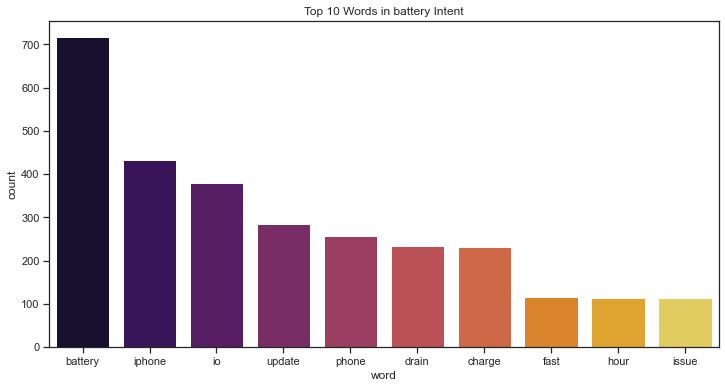

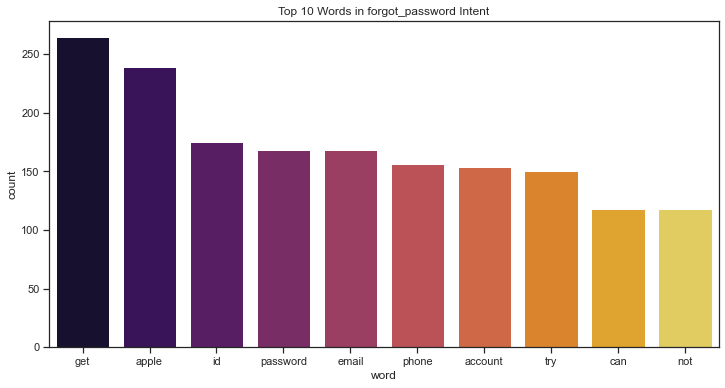

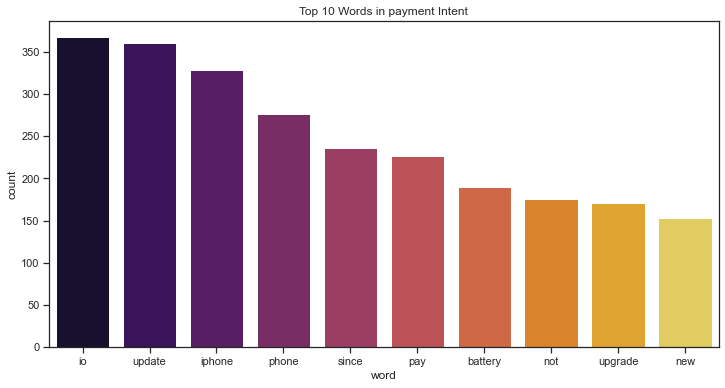

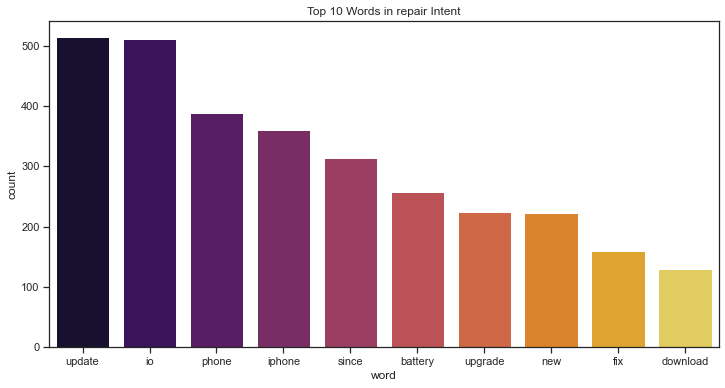

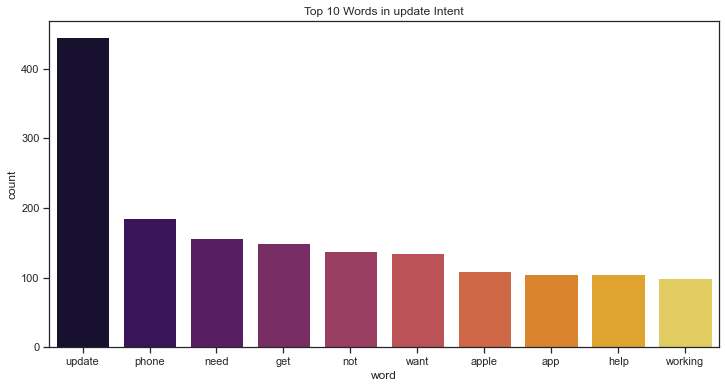

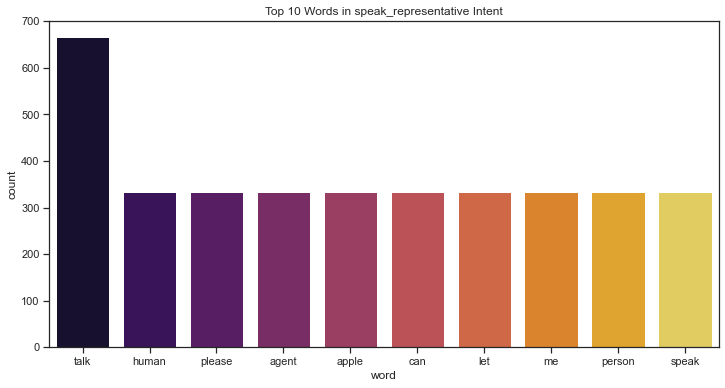

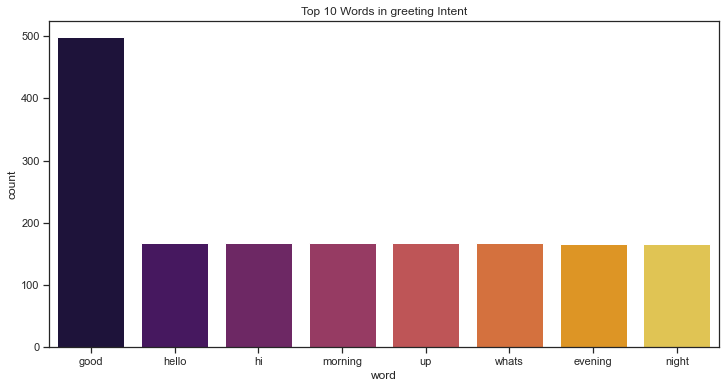

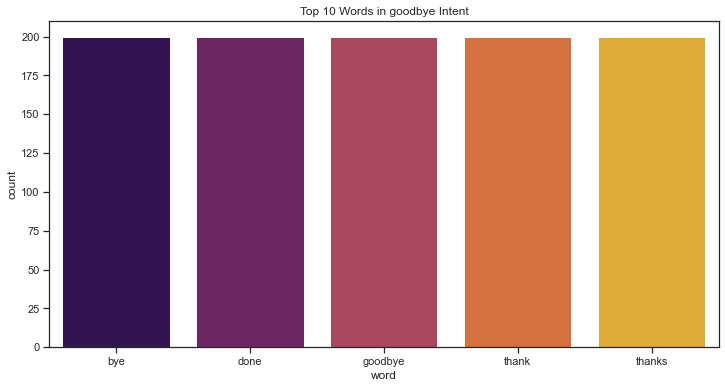

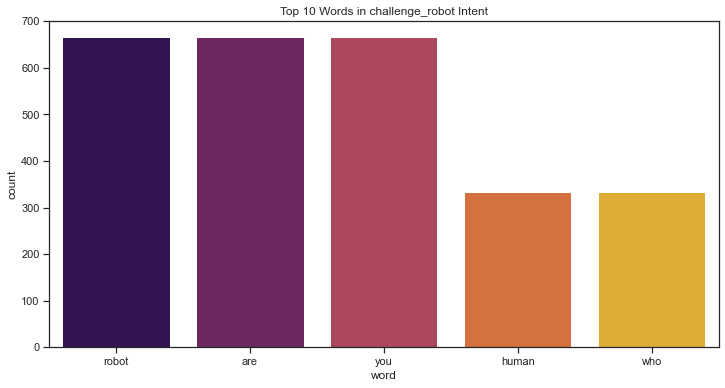

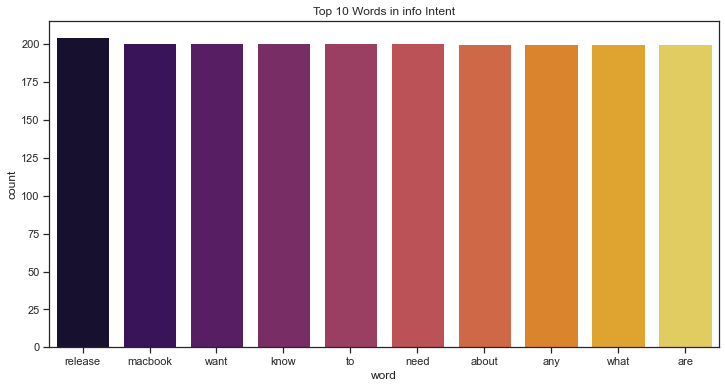

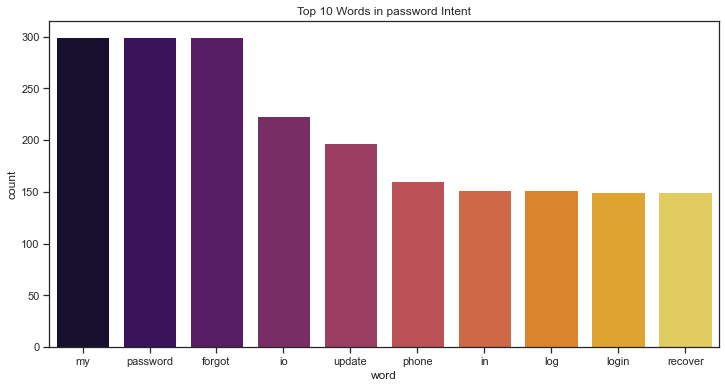

In [179]:
# Doing my bucket evaluations here - seeing what each distinct bucket intent means
for i in train.columns:
    top10_bagofwords(train[i].apply(" ".join), f'bucket_eval/{i}', f'Top 10 Words in {i} Intent')

Initial thoughts:

To be honest, I feel like the way I should get my training data for greeting is not the best. There are a lot of words that are similar between buckets. As an example, for mac, it's a little concerning that iphone is the most common word!

After changing method (version 2):

The words and results make a lot more sense.

In [183]:
# Investigating bag of word frequencies at a more granular level
wordranks['bucket_eval/mac'].head(50)

,word,count
849,iphone,304
1777,update,256
841,io,225
79,app,208
1614,store,164
84,apple,140
1459,screen,139
729,help,134
95,apps,121
1073,new,114


In [19]:
[*train.columns]

['battery', 'forgot_password', 'lost_replace', 'payment', 'repair', 'update']

### Generating text file for rasa
Rasa API requires this format of data to be inputted into their bot. I work with my own training data in train, however this was made for experimenting with their tool.

In [44]:
# Getting NLU.md training data in correct form for Rasa Bot
with open('data/train_rasa/train_v3.txt', 'w') as t:
    for intent in train.columns:
        t.write(f'## intent: {intent}\n')
        for tweet in train[intent]:
            t.write('- ' + " ".join(tweet) + '\n')
        t.write('\n')

### This is just a cell to log my progress of how my method was doing at first

Tweets with similarities without emojis to `['new', 'update', 'i️', 'make', 'sure', 'download', 'yesterday']`

Format is: `(index tag, cosine similarity)`

[('72326', 0.8154675364494324),
 ('32166', 0.8151031732559204),
 ('29461', 0.8027088642120361),
 ('5942', 0.7968393564224243),
 ('54836', 0.7879305481910706),
 ('30359', 0.7861931324005127),
 ('66201', 0.7817540168762207),
 ('50109', 0.7796376943588257),
 ('59490', 0.7793254852294922),
 ('46644', 0.7775745391845703),
 ('58410', 0.7734568119049072),
 ('26164', 0.7674931287765503),
 ('14867', 0.7673683166503906),
 ('25813', 0.766610860824585),
 ('47880', 0.7642890214920044),
 ('30945', 0.76273113489151),
 ('74155', 0.7582229971885681),
 ('33346', 0.7577282190322876),
 ('9502', 0.7569847702980042),
 ('64871', 0.7567278146743774)

### Using scattertext from the spaCy universe for EDA
This [kernel](https://www.kaggle.com/psbots/customer-support-meets-spacy-universehttps://www.kaggle.com/psbots/customer-support-meets-spacy-universe) showed me what spaCy's scattertext tool is capable of doing! So I wanted to do it myself as well to hopefully get useful insights.

As said in the docs, scatter-text is "a tool for finding distinguishing terms in small-to-medium-sized corpora, and presenting them in a sexy, interactive scatter plot with non-overlapping term labels."

However, the `CorpusFromParsedDocuments` implemented in that kernel seemed to be deprecated or had a dependency issue, so I looked at the docs and used `CorpusFromPandas` instead, which I think is very suitable especially for the data I have.

In [86]:
def term_freqs(intent_name):
    bagofwords = CountVectorizer()
    # Output will be a sparse matrix
    inbound = bagofwords.fit_transform(visualize_train[visualize_train['Intent'] == intent_name]['Utterance'])
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    words = np.array(bagofwords.get_feature_names())
    words_df = pd.DataFrame({"word":words, 
                                 "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    return words_rank

update_df = term_freqs('update')
repair_df = term_freqs('repair')

combined = pd.concat([update_df, repair_df], axis = 0)

In [47]:
import spacy
import scattertext as st

In [84]:
# Data munging
visualize_train = neat_train.copy()
visualize_train['Utterance'] = visualize_train['Utterance'].progress_apply(" ".join)

# Subsetting to the two intents I want to compare
visualize_train = visualize_train[(visualize_train['Intent'] == 'repair') | 
                                 (visualize_train['Intent'] == 'update')]

# Load spacy model
nlp = spacy.load('en',disable_pipes=["tagger","ner"])
visualize_train['parsed'] = visualize_train['Utterance'].progress_apply(nlp)

In [94]:
visualize_train.head()

,Utterance,Intent,parsed
3,repair fix broken,repair,"(repair, fix, broken)"
4,want update,update,"(want, update)"
12,not work broken,repair,"(not, work, broken)"
13,update not working,update,"(update, not, working)"
21,repair fix broken,repair,"(repair, fix, broken)"


In [95]:
corpus = st.CorpusFromParsedDocuments(visualize_train,
                             category_col='Intent',
                             parsed_col='parsed').build()

In [98]:
html = st.produce_scattertext_explorer(corpus,
          category='Intent',
          category_name='repair',
          not_category_name='update',
          width_in_pixels=600,
          minimum_term_frequency=10,
        term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
          )

AssertionError: 